# Le Filtrage Collaboratif (Collaborative Filtering)

### Table des matières <a id="0"></a>
- [Packages](#1)
- [Notation](#2)
- [Propos de l'ensemble de données](#3)
- [ACP](#6)
- [L'algorithme du filtrage collaboratif](#4)
  - [Fonction de perte](#4.1)
  - [Descente de gradient](#4.2)
- [Évaluation](#5)

## Packages. <a id="1"></a>

NumPy, Pandas et TensorFlow sont les packages utiles dans ce projet.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
import sys
sys.path.append("../Python_file")

from FonctionUtile import *
from PCA import *

## Notation. <a id="2"></a>

\begin{array}{|l|l|l|}
\hline
\text{Notation} & \text{Description} & \text{Python (le cas échéant)} \\
\hline
r(i,j) & \text{scalaire; } = 1 \text{ si l'utilisateur } j \text{ a évalué le film } i, = 0 \text{ sinon} & \\
y(i,j) & \text{scalaire; note donnée par l'utilisateur } j \text{ pour le film } i \text{ (si } r(i,j) = 1 \text{ est défini)} & \\
\mathbf{w}^{(j)} & \text{vecteur; paramètres pour l'utilisateur } j & \\
\mathbf{x}^{(i)} & \text{vecteur; caractéristiques du film } i & \\
b^{(i,j)} & \text{scalaire; paramètre de biais pour le film } i \text{ et l'utilisateur } j & \text{b}\\
b_u^{(j)} & \text{scalaire; paramètre de biais pour l'utilisateur } j &  \\
b_f^{(i)} & \text{scalaire; paramètre de biais pour le film } i  &  \\
b_u & \text{vecteur; paramètres de biais pour l'utilisateur } j & \text{b\_u} \\
b_f & \text{vecteur; paramètres de biais pour le film } i  & \text{b\_f} \\
n_u & \text{nombre d'utilisateurs} & \text{nb\_utilisateurs} \\
n_f & \text{nombre de films} & \text{nb\_films} \\
k & \text{nombre de caractéristiques} & \text{nb\_caracs} \\
\mathbf{X} & \text{matrice de vecteurs } \mathbf{x}^{(i)} & \text{X} \\
\mathbf{W} & \text{matrice de vecteurs } \mathbf{w}^{(j)} & \text{W} \\
\mathbf{B} & \text{matrice de paramètres de biais } b^{(i,j)} & \text{B} \\
\mathbf{R} & \text{matrice des éléments } r(i,j) & \text{R} \\
\mathbf{Y} & \text{matrice des éléments } y(i,j) & \text{Y} \\
\mathbf{\hat{Y}} & \text{matrice approximative de } \mathbf{Y} & \\
\hline
\end{array}

## Propos de l'ensemble de données. <a id="3"></a>

In [3]:
#importer les données
Y,R = data_ratings()
nb_caracs = 10 # Choisissez 10 car ce nombre réduit le coût tout en étant suffisamment grand pour un grand ensemble de données.
print("Matrix Y dim ", Y.shape)
print("Matrix R dim ", R.shape)
nb_films, nb_utilisateurs=Y.shape
print("Nombre de films: ", nb_films)
print("Nombre d'utilisateurs: ", nb_utilisateurs)
print("Nombre de caracteristiques: ", nb_caracs)

Matrix Y dim  (9724, 610)
Matrix R dim  (9724, 610)
Nombre de films:  9724
Nombre d'utilisateurs:  610
Nombre de caracteristiques:  10


Il est nécessaire de savoir que dans la matrice des notes $Y$, les notes vont de 0.5 à 5 par intervalles de 0.5. Toutes les cellules à 0 signifient que les clients n'ont pas encore donné de note ou n'ont pas voté.

La matrice $Y$ est une matrice creuse dans la plupart des applications, car seule une petite fraction de ses éléments est différente de zéro.

In [4]:
print("Nombre de cellules dans Y : ", nb_utilisateurs * nb_films)
print("Nombre de notes attribuées : ", R.sum())
print("Taux de notes attribuées par rapport à toutes les cellules : ", (R.sum() / (nb_utilisateurs * nb_films)) * 100, "%")

Nombre de cellules dans Y :  5931640
Nombre de notes attribuées :  100836
Taux de notes attribuées par rapport à toutes les cellules :  1.6999683055613624 %


**J'ajoute le nouvel utilisateur dans le but de lui faire [des recommandations par la suite](#rec).** <a id="new-user"></a>

In [5]:
#initialize mes notes
mes_notes = np.zeros(nb_films)

#Regarder le fichier 'movise_list.csv'
mes_notes[0]=1 # Si je ne préfére pas ce film
mes_notes[0]=5 # Si j préfére ce film

#Je crée mes listes de notes. Les notes doivent être entières
# L'index maximum correspond au (nombre total de films -1)
mes_notes[0]= 5    # Toy story (1995)
mes_notes[483]=3    # Nightmare Before Christmas, The (1993)
mes_notes[480]=2   # Terminal Velocity (1994)
mes_notes[1402]=2   # Pi (1998)
mes_notes[1400]=4   # Madeline (1998)
mes_notes[2695]=5   # Loser (2000)
mes_notes[2696]=4   # Road Trip (2000)
mes_notes[2734]=3  # Benji(1974)
mes_notes[3090]=1   # Hannibal(2001)
mes_notes[3942]=3   # Time after Time (1979)
mes_notations=     [i for i in range(len(mes_notes)) if mes_notes[i] > 0]# Stocke les indices des films que j'ai notés

In [6]:
# Ajouter un nouvel utilisateur à la matrice Y.
Y = np.c_[mes_notes, Y] #Le nouvel utilisateur ajouté occupe l'indice 0 dans la colonne des utilisateurs

# Ajouter l'indicateur de nouvel utilisateur à la matrice R
R = np.c_[(mes_notes != 0).astype(int), R]

Le nombre de films et d'utilisateurs est maintenant le suivant :

In [7]:
print("Matrix Y dim ", Y.shape)
print("Matrix R dim ", R.shape)
nb_films, nb_utilisateurs=Y.shape
print("Nombre de films: ", nb_films)
print("Nombre d'utilisateurs: ", nb_utilisateurs)

Matrix Y dim  (9724, 611)
Matrix R dim  (9724, 611)
Nombre de films:  9724
Nombre d'utilisateurs:  611


In [8]:
#Charger les données pour la fonction de pré-calcul.
Ymean, Ynorm = normalizeRatings(Y,R)
print("Matrix note moyenne dim ", Ymean.shape)
print("Matrix note normalisé dim ", Ynorm.shape)

Matrix note moyenne dim  (9724, 1)
Matrix note normalisé dim  (9724, 611)


Maintenant, nous calculons la note moyenne pour chaque film par la $i$-ème ligne de la matrice $Y$, en excluant les zéros, c'est-à-dire uniquement les films qui ont été évalués sont inclus.

On calcule les biais des utilisateurs et des films, ainsi que la moyenne de toutes les notes.

In [9]:
#Charger les données pour la fonction de pré-calcul.
utilisateur_ratings,film_ratings =  dict_evaluations()#origine 

# On utilise .copy() pour éviter que utilisateur_ratings et film_ratings 
# ne soient modifiés lorsqu'ils sont passés à la fonction update_dict_evaluations. 
# Cela permet de travailler avec des copies indépendantes des dictionnaires d'origine.
utilisateur_ratings_updated,film_ratings_updated = update_dict_evaluations(Y, utilisateur_ratings.copy(),film_ratings.copy())
print(f"La taille de dict utilisateur_ratings : {len(utilisateur_ratings)}")
print(f"La taille de dict utilisateur_ratings_updated : {len(utilisateur_ratings_updated)}")
mu,b_u,b_f = bias_param(Y, utilisateur_ratings_updated.copy(), film_ratings_updated.copy())
print(f"Total biais de l'utilisateur : {len(b_u)}")
print(f"Total biais du film: {len(b_f)}")
print(f"La moyenne de Ymean : {np.mean(Ymean)}")
print(f"La moyenne de toutes les notes : {mu}")

La taille de dict utilisateur_ratings : 610
La taille de dict utilisateur_ratings_updated : 611
Total biais de l'utilisateur : 611
Total biais du film: 9724
La moyenne de Ymean : 3.2624895815718498
La moyenne de toutes les notes : 3.501527080895623


En effet, la moyenne de $\mathbf Ymean$ (c'est-à-dire la moyenne des moyennes de chaque film) n'est pas la même que la moyenne de toutes les notes, simplement parce que dans la moyenne de toutes les notes ($\mu$), chaque évaluation est considérée comme une valeur ponctuelle, donc toutes les évaluations ont un poids égal. Dans la moyenne de Ymean, vous calculez d'abord la moyenne pour chaque film. Cela peut augmenter ou diminuer le poids des films en fonction du nombre d'évaluations que chaque film reçoit.

In [10]:
B = Biais_matrix(b_f,b_u,mu,Y)
print(B.shape)

(9724, 611)


## l'ACP <a id="6"></a>

Dans ce projet, nous avons deux types de modèles.

**Premier type (Modèle initial et Ajustement principal du modèle)** :  
Dans cette approche, nous ajustons le modèle en fonction de la matrice des évaluations $Y$. L'objectif est de réduire la dimension de cette matrice $Y$, ce qui nous permet de simplifier le problème tout en conservant l'information essentielle. Cependant, cette approche traite directement les évaluations d'origine sans effectuer de transformations supplémentaires sur les données.

**Deuxième type (Modèles avec ajustements supplémentaires)** :  
Ici, nous travaillons avec des modèles qui ajustent les évaluations normalisées $Y_{norm}$. Parmi ces modèles, l'un d'eux utilise la matrice pré-calculée $B$, ce qui nous amène également à réduire la dimension de cette matrice $B$ afin de l'adapter à la réduction de la dimension de $Y$.

Nous pouvons visualiser les utilisateurs comme des *features* de chaque film. Cela signifie que nous pouvons obtenir une meilleure compréhension de la façon dont un film est évalué par les utilisateurs, en fonction des interactions avec ces derniers. Cette approche nous permet de construire une matrice carrée des *features* des films, avec des dimensions égales à $\textbf{nb\_d'utilisateur} \times \textbf{nb\_d'utilisateur}$, où chaque entrée représente une relation ou une interaction entre deux utilisateurs à propos des films qu'ils ont évalués.

À partir d'une matrice des *features* des films, nous calculons les matrices de covariance correspondantes.


In [11]:
covar_matriceY = matrix_covariance(Y)
covar_matriceYnorm = matrix_covariance(Ynorm)
covar_matriceB = matrix_covariance(B)

Ensuite, nous calculons les valeurs propres ainsi que les vecteurs propres afin de déduire une matrice de projection (ACP). Nous trions ensuite les vecteurs propres par ordre décroissant.

In [12]:
eigenvaluesY, eigenvectorsY = eigen(covar_matriceY)
eigenvaluesYnorm, eigenvectorsYnorm = eigen(covar_matriceYnorm)
eigenvaluesB, eigenvectorsB = eigen(covar_matriceB)

Puis, il faut calculer la variance expliquée afin de déterminer combien de vecteurs propres utiliser pour conserver les composantes principales les plus importantes. Dans ce projet, je souhaite conserver 95 % de la variance.


In [13]:
CEV_Y,var_expl_ratioY=cumulative_explained_variance(eigenvaluesY, normalized=False)
CEV_Ynorm,var_expl_ratioYnorm=cumulative_explained_variance(eigenvaluesYnorm, normalized=False)

Les valeurs propres ont été normalisées
Les valeurs propres ont été normalisées


On identifie l'indice où la valeur de la fonction $\textbf{cumulative\_explained\_variance}$ dépasse 95 %. Ensuite, on utilise cet indice pour construire la matrice ACP de taille $\textbf{nb\_utilisateur} \times \textbf{indice}$, qui contient les composantes principales les plus significatives.


In [14]:
indice_95Y = np.searchsorted(CEV_Y, 0.95)  # Trouver l'indice où la variance cumulative atteint ou dépasse 0,95
print("L'indice où la variance cumulative atteint 95%:", indice_95Y)
print(f"Rapport de variance expliquée: {CEV_Y[indice_95Y]}")

L'indice où la variance cumulative atteint 95%: 455
Rapport de variance expliquée: 0.950336234129197


In [15]:
indice_95Ynorm = np.searchsorted(CEV_Ynorm, 0.95)  # Trouver l'indice où la variance cumulative atteint ou dépasse 0,95
print("L'indice où la variance cumulative atteint 95%:", indice_95Ynorm)
print(f"Rapport de variance expliquée: {CEV_Ynorm[indice_95Ynorm]}")

L'indice où la variance cumulative atteint 95%: 475
Rapport de variance expliquée: 0.9503155080065531


In [16]:
t = indice_95Y
matrice_projectionY=eigenvectorsY[:,:t]

In [17]:
newY=np.dot(Y,matrice_projectionY)
print("La dimension de Y dans l'espace de dimension réduite :", newY.shape)

La dimension de Y dans l'espace de dimension réduite : (9724, 455)


In [18]:
v = indice_95Ynorm
matrice_projectionYnorm=eigenvectorsYnorm[:,:v]
matrice_projectionB=eigenvectorsB[:,:v]

In [19]:
newYnorm=np.dot(Ynorm,matrice_projectionYnorm)
newB=np.dot(B,matrice_projectionB)
print("La dimension de Ynorm dans l'espace de dimension réduite :", newYnorm.shape)
print("La dimension de B dans l'espace de dimension réduite :", newB.shape)

La dimension de Ynorm dans l'espace de dimension réduite : (9724, 475)
La dimension de B dans l'espace de dimension réduite : (9724, 475)


On observe que désormais, la dimension réduite des matrices ne contient plus 611 utilisateurs. En revanche, elle est de 455 pour la matrice $newY$ et de 475 pour les matrices $newYnorm$ et $newB$. Cela s'explique par le fait que les informations les plus importantes des 611 utilisateurs ont été condensées.

In [20]:
print(newY.dtype,newYnorm.dtype,newB.dtype)

float64 float64 complex128


Les valeurs dans la dimension réduite de la matrice $B$ sont des nombres complexes, ce qui pose des difficultés lors des calculs avec d'autres variables de types différents.

In [21]:
newB=tf.math.real(newB)
print(newB.dtype)

<dtype: 'float64'>


On initialise la matrice des paramètres utilisateur $W$ et la matrice des paramètres des films $X$, où $X$ stocke les vecteurs de paramètres des utilisateurs $\mathbf{x}^{(i)}$, tandis que la matrice $W$ stocke les vecteurs de paramètres des films $\mathbf{w}^{(j)}$ afin d'entraîner le modèle. Avec cet ensemble de données, on choisit le nombre de caractéristiques $k = 10$.

Pour le modèle type 1 : Modèle initial et Ajustement principal du modèle

In [22]:
np.random.seed(28) # for consistent results
W_initiale_pca1 = np.random.normal(size=(nb_caracs, t))
X_initiale_pca1 = np.random.normal(size=(nb_films, nb_caracs))
print("Matrix W dim ", W_initiale_pca1.shape)
print("Matrix X dim ", X_initiale_pca1.shape)

Matrix W dim  (10, 455)
Matrix X dim  (9724, 10)


Pour le modèle type 2 : Modèles avec ajustements supplémentaires

In [23]:
np.random.seed(28) # for consistent results
W_initiale_pca2 = np.random.normal(size=(nb_caracs, v))
X_initiale_pca2 = np.random.normal(size=(nb_films, nb_caracs))
print("Matrix W dim ", W_initiale_pca2.shape)
print("Matrix X dim ", X_initiale_pca2.shape)

Matrix W dim  (10, 475)
Matrix X dim  (9724, 10)


In [24]:
new_mu = np.mean(newY[newY != 0])
print(new_mu)

-0.0012504759085286735


## L'algorithme du filtrage collaboratif.<a id="4"></a>

### 1. fonction de perte. <a id="4.1"></a>

#### Le modèle initial

$$\begin{align}
\mathcal{L}(\mathbf{x^{(i)}}, \mathbf{w^{(j)}}, \mathbf{b_u}^{(j)},\mathbf{b_m}^{(i)})= \frac{1}{2} & \sum_{(i,j) : r(i,j) = 1}  \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b_u}^{(j)} + \mathbf{b_m}^{(i)} +\mu - y(i,j) \right)^2  + \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b_u}^{(j)})^2 + (\mathbf{b_m}^{(i)})^2 \right) }_{\text{regularization}} 
\end{align} $$

In [25]:
def FonctionPerte_Init(W,X,b_u,b_f,Y,lambda_,mu):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   b_u (ndarray (1, nb_utilisateur)) : vecteur des parametres de biais.
   b_f (ndarray (nb_films, 1)) : vecteur des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   lambda_ (float): paramètre de régularisation
   mu (float) : la moyenne de toutes les évaluations attribuées
 Retourne :
   L (float): valeur de perte
   """
    
   l = (tf.linalg.matmul(X, W) + b_u + b_f + mu - Y)
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(b_u**2)+tf.reduce_sum(b_f**2))
   return L

#### L'ajustement du modèle

$$
\mathcal{L}(\mathbf{x^{(i)}}, \mathbf{w^{(j)}}, \mathbf{b}^{(i,j)}) = \frac{1}{2} \sum_{(i,j) : r(i,j) = 1} \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b}^{(i,j)} + \mu - y(i,j) \right)^2
+ \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b}^{(i,j)})^2 \right) }_{\text{regularization}} 
$$


In [26]:
def FonctionPerte_Ajust(W,X,B,Y,lambda_,mu):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   B (ndarray (nb_films, nb_utilisateurs)) : matrice des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   lambda_ (float): paramètre de régularisation
   mu (float) : la moyenne de toutes les évaluations attribuées
 Retourne :
   L (float): valeur de perte
   """
   l = (tf.linalg.matmul(X, W) + B + mu - Y)
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(B**2))
   return L

#### Des ajustements supplémentaires du modèle: 

##### l'Approche 1: ne fonctionne pas dans ce cas avec l'application de la PCA.

$$\begin{align}
\mathcal{L}({\mathbf{x^{(i)}}, \mathbf{w^{(j)}}, \mathbf{b_u^{(j)}}, \mathbf{b_m^{(i)}}})= \frac{1}{2} & \sum_{(i,j) : r(i,j) = 1}  \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b_u}^{(j)} + \mathbf{b_m}^{(i)} - y_{\text{norm}}(i,j) \right)^2 + \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b_u}^{(j)})^2 + (\mathbf{b_m}^{(i)})^2 \right) }_{\text{regularization}} 
\end{align} $$

In [27]:
def FonctionPerte_Sup1(W,X,b_u,b_f,Y,lambda_):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   b_u (ndarray (1, nb_utilisateur)) : vecteur des parametres de biais.
   b_f (ndarray (nb_films, 1)) : vecteur des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   lambda_ (float): paramètre de régularisation
 Retourne :
   L (float): valeur de perte
   """
   l = (tf.linalg.matmul(X, W) + b_u + b_f - Y)
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(b_u**2)+tf.reduce_sum(b_f**2))
   return L

##### l'Approche 2:

$$\begin{align}
\mathcal{L}(\mathbf{w}^{(j)}, \mathbf{x}^{(i)}, \mathbf{b}^{(i,j)}) = &  \frac{1}{2}  \sum_{(i,j): r(i,j) = 1}  \left( \mathbf{x}^{(i)} \cdot \mathbf{w}^{(j)} + \mathbf{b}^{(i,j)} - y_{\text{norm}}(i,j) \right)^2 + \underbrace{ \frac{\lambda}{2} \left( ||\mathbf{w}^{(j)}||^2 + ||\mathbf{x}^{(i)}||^2 + (\mathbf{b}^{(i,j)})^2 \right) }_{\text{regularization}} \label{eq:cost_function_B}
\end{align}$$

In [28]:
def FonctionPerte_Sup2(W,X,B,Y,lambda_):
   """
 Arguments :
   X (ndarray (nb_films, nb_caracs)): matrice des caractéristiques des films
   W (ndarray (nb_caracs, nb_utilisateurs)): matrice des paramètres des utilisateurs
   B (ndarray (nb_films, nb_utilisateurs)) : matrice des parametres de biais.
   Y (ndarray (nb_films,nb_utilisateurs)): matrice des évaluations des utilisateurs pour les films
   lambda_ (float): paramètre de régularisation
 Retourne :
   L (float): valeur de perte
   """
   l = (tf.linalg.matmul(X, W) + B - Y)
   L = 0.5 * tf.reduce_sum(l**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2)+tf.reduce_sum(B**2))
   return L

### 2. Descente de gradient. <a id="4.2"></a>

In [29]:
import time  
wall_times = []  # Liste pour stocker les temps de Wall time
cpu_times = []   # Liste pour stocker les temps de CPU time

#### 2.1 Le modèle initial

In [30]:
opti1 = keras.optimizers.Adam(learning_rate=1e-1)#le taux d'apprentissage Adam

In [31]:
def suivre_variables_init(X_initial, W_initial):
    W = tf.Variable(W_initial, name='W')     # matrice W 
    X = tf.Variable(X_initial, name='X')     # matrice X 
    bu = tf.Variable(tf.random.normal((1,          t),   dtype=tf.float64),  name='b_u')
    bf = tf.Variable(tf.random.normal((nb_films,          1),   dtype=tf.float64),  name='b_f')
    return X, W, bu,bf #4 paramètres à suivre

In [32]:
X1,W1,b_u1,b_f1 = suivre_variables_init(X_initiale_pca1, W_initiale_pca1)

In [33]:
Perte=FonctionPerte_Init(W_initiale_pca1,X_initiale_pca1,b_u1,b_f1,newY,0,new_mu)
PerteRegul=FonctionPerte_Init(W_initiale_pca1,X_initiale_pca1,b_u1,b_f1,newY,1,new_mu)
print(f"La valeur de perte (sans regularisation): {Perte:0.3f}")
print(f"La valeur de perte (avec regularisation): {PerteRegul:0.3f}")

La valeur de perte (sans regularisation): 26827886.322
La valeur de perte (avec regularisation): 26883811.661


In [34]:
def GD_modele_init(W,X,b_u,b_f,Y,lambda_,iterations,taux_apprenti,mu): #Gradient descent pour le modèle initial
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la perte
    with tf.GradientTape() as tape:

        # Calculer la fonction de perte
        valeur_perte = FonctionPerte_Init(W,X,b_u,b_f,Y,lambda_,mu)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,b_u,b_f])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,b_u,b_f]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W,b_u,b_f,valeur_perte]

In [35]:
start_wall = time.time()  
start_cpu = time.process_time()
[X1,W1,b_u1,b_f1,valeur_perte1]= GD_modele_init(W1,X1,b_u1,b_f1,newY,1,500,opti1,new_mu)
end_wall = time.time()  
end_cpu = time.process_time() 
wall_times.append(end_wall - start_wall)  
cpu_times.append(end_cpu - start_cpu) 

Perte d'entraînement à l'itération 0: 26883811.66
Perte d'entraînement à l'itération 100: 441034.42
Perte d'entraînement à l'itération 200: 399450.52
Perte d'entraînement à l'itération 300: 386653.79
Perte d'entraînement à l'itération 400: 383424.91
Perte d'entraînement à l'itération 499: 382474.04


On remarque qu'entre les itérations 400 et 500, ***la perte ne diminue pas de manière significative. On peut envisager de fixer le nombre d'itérations à 400 ou 500***.

#### 2.2 L'ajustement du modèle

In [36]:
opti2 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [37]:
def suivre_variables_ajust(X_initial, W_initial):
    W = tf.Variable(W_initial, name='W')     
    X = tf.Variable(X_initial, name='X')   
    B = tf.Variable(tf.random.normal((nb_films,          t),   dtype=tf.float64),  name='B') #initialiser aleatoirement
    return X, W, B # 3 paramètres à suivre

In [38]:
X2,W2,B2 = suivre_variables_ajust(X_initiale_pca1, W_initiale_pca1)

In [39]:
Perte=FonctionPerte_Ajust(W_initiale_pca1,X_initiale_pca1,B2,newY,0,new_mu)
PerteRegul=FonctionPerte_Ajust(W_initiale_pca1,X_initiale_pca1,B2,newY,1,new_mu)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 24506719.471
La Perte (avec regularisation): 26768232.029


In [40]:
def GD_modele_ajust(W,X,B,Y,lambda_,iterations,taux_apprenti,mu):
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la perte
    with tf.GradientTape() as tape:

        # Calculer la perte
        valeur_perte = FonctionPerte_Ajust(W,X,B,Y,lambda_,mu)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,B])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,B]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W,B,valeur_perte]

In [41]:
start_wall = time.time()  
start_cpu = time.process_time()
[X2,W2,B2,valeur_perte2]= GD_modele_ajust(W2,X2,B2,newY,1,500,opti2,new_mu) 
end_wall = time.time()  
end_cpu = time.process_time() 
wall_times.append(end_wall - start_wall)  
cpu_times.append(end_cpu - start_cpu) 

Perte d'entraînement à l'itération 0: 26768232.03
Perte d'entraînement à l'itération 100: 242722.15
Perte d'entraînement à l'itération 200: 212263.45
Perte d'entraînement à l'itération 300: 201594.29
Perte d'entraînement à l'itération 400: 196473.58
Perte d'entraînement à l'itération 499: 194710.79


#### 2.3 Des ajustements supplémentaires du modèle
##### l'Approche 1.A peut pas PCA

##### l'Approche 1.B

In [42]:
opti4 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [43]:
def suivre_variables_1B(X_initial, W_initial):
    W4 = tf.Variable(W_initial, name='W')     
    X4 = tf.Variable(X_initial, name='X')     
    b_u4 = tf.Variable(tf.random.normal((1,          v),   dtype=tf.float64),  name='b_u') #initialiser aleatoirement
    b_f4 = tf.Variable(tf.random.normal((nb_films,          1),   dtype=tf.float64),  name='b_f') #initialiser aleatoirement
    return X4, W4, b_u4, b_f4

In [44]:
X4, W4,b_u4,b_f4 = suivre_variables_1B(X_initiale_pca2, W_initiale_pca2)

In [45]:
def GD_modele_Sup1(W,X,b_u,b_f,Y,lambda_,iterations,taux_apprenti):
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la Perte
    with tf.GradientTape() as tape:

        # Calculer la Perte 
        valeur_perte = FonctionPerte_Sup1(W, X, b_u,b_f, Y, lambda_)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,b_u,b_f])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,b_u,b_f]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle:
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W,b_u,b_f,valeur_perte]

In [46]:
Perte=FonctionPerte_Sup1(W_initiale_pca2,X_initiale_pca2,b_u4,b_f4,newYnorm,0)
PerteRegul=FonctionPerte_Sup1(W_initiale_pca2,X_initiale_pca2,b_u4,b_f4,newYnorm,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 27650291.366
La Perte (avec regularisation): 27706397.952


In [47]:
start_wall = time.time()  
start_cpu = time.process_time()
[X4, W4,b_u4,b_f4,valeur_perte4]= GD_modele_Sup1(W4,X4,b_u4,b_f4,newYnorm,1,500,opti4) 
end_wall = time.time()  
end_cpu = time.process_time() 
wall_times.append(end_wall - start_wall)  
cpu_times.append(end_cpu - start_cpu) 

Perte d'entraînement à l'itération 0: 27706397.95
Perte d'entraînement à l'itération 100: 38358.80
Perte d'entraînement à l'itération 200: 36457.06
Perte d'entraînement à l'itération 300: 34792.37
Perte d'entraînement à l'itération 400: 33569.70
Perte d'entraînement à l'itération 499: 32700.42


##### l'Approche 2.A

In [48]:
opti5 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [49]:
def suivre_variables_2A(X_initial, W_initial, B):
    W5 = tf.Variable(W_initial, name='W')   
    X5 = tf.Variable(X_initial, name='X')  
    B5 = tf.Variable(B, name='B') # valeur pré-calculée à suivre
    return X5, W5, B5

In [50]:
X5, W5,B5 = suivre_variables_2A(X_initiale_pca2, W_initiale_pca2, newB)

In [51]:
Perte=FonctionPerte_Sup2(W_initiale_pca2,X_initiale_pca2,B5,newYnorm,0)
PerteRegul=FonctionPerte_Sup2(W_initiale_pca2,X_initiale_pca2,B5,newYnorm,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 25273659.357
La Perte (avec regularisation): 27933341.014


In [52]:
def GD_modele_Sup2(W,X,B,Y,lambda_,iterations,taux_apprenti):
 for iter in range(iterations):
    # Enregistrer les opérations utilisées pour calculer la perte
    with tf.GradientTape() as tape:

        # Calculer la perte
        valeur_perte = FonctionPerte_Sup2(W, X, B, Y, lambda_)

    # Récupérer automatiquement les gradients des variables entraînables par rapport à la perte
    grads = tape.gradient(valeur_perte, [X, W,B])

    # Exécuter une étape de descente de gradient en mettant à jour la valeur des variables pour minimiser la perte
    taux_apprenti.apply_gradients(zip(grads, [X, W,B]))
    
    #journaliser périodiquement.
    if iter % 100 == 0: # Imprimer les valeurs de 0 à 400 inclus.
        print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 if iter % 100 != 0:  # Imprimer le dernier boucle
   print(f"Perte d'entraînement à l'itération {iter}: {valeur_perte:0.2f}")
 return [X, W, B,valeur_perte]

In [53]:
start_wall = time.time()  
start_cpu = time.process_time()
[X5, W5,B5,valeur_perte5]= GD_modele_Sup2(W5,X5,B5,newYnorm,1,500,opti5)
end_wall = time.time()  
end_cpu = time.process_time() 
wall_times.append(end_wall - start_wall)  
cpu_times.append(end_cpu - start_cpu) 

Perte d'entraînement à l'itération 0: 27933341.01
Perte d'entraînement à l'itération 100: 1344783.45
Perte d'entraînement à l'itération 200: 818809.26
Perte d'entraînement à l'itération 300: 495244.53
Perte d'entraînement à l'itération 400: 300939.47
Perte d'entraînement à l'itération 499: 185384.48


##### l'Approche 2.B

In [54]:
opti6 = keras.optimizers.Adam(learning_rate=1e-1) #le taux d'apprentissage Adam

In [55]:
def suivre_variables_2B(X_initial, W_initial):
    W6 = tf.Variable(W_initial, name='W')     
    X6 = tf.Variable(X_initial, name='X')    
    B6 = tf.Variable(tf.random.normal((nb_films,          v),   dtype=tf.float64),  name='B') #initialiser aleatoirement
    return X6, W6, B6

In [56]:
X6, W6,B6 = suivre_variables_2B(X_initiale_pca2, W_initiale_pca2)

In [57]:
Perte=FonctionPerte_Sup2(W_initiale_pca2,X_initiale_pca2,B6,newYnorm,0)
PerteRegul=FonctionPerte_Sup2(W_initiale_pca2,X_initiale_pca2,B6,newYnorm,1)
print(f"La Perte (sans regularisation): {Perte:0.3f}")
print(f"La Perte (avec regularisation): {PerteRegul:0.3f}")

La Perte (sans regularisation): 24977250.462
La Perte (avec regularisation): 27336144.027


In [58]:
start_wall = time.time()  
start_cpu = time.process_time()
[X6, W6,B6,valeur_perte6]= GD_modele_Sup2(W6,X6,B6,newYnorm,1,500,opti6) 
end_wall = time.time()  
end_cpu = time.process_time() 
wall_times.append(end_wall - start_wall)  
cpu_times.append(end_cpu - start_cpu) 

Perte d'entraînement à l'itération 0: 27336144.03
Perte d'entraînement à l'itération 100: 22789.69
Perte d'entraînement à l'itération 200: 20051.83
Perte d'entraînement à l'itération 300: 19147.83
Perte d'entraînement à l'itération 400: 18262.48
Perte d'entraînement à l'itération 499: 17657.13


#### 2.3 Comparaison entre la valeur de perte entre des modèles.

In [59]:
print(f"La valeur obtenue après l'entraînement du modèle initial   : {valeur_perte1:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement du modèle   : {valeur_perte2:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (1B)   : {valeur_perte4:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2A)   : {valeur_perte5:0.3f}")
print(f"La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2B)   : {valeur_perte6:0.3f}")

La valeur obtenue après l'entraînement du modèle initial   : 382474.039
La valeur obtenue après l'entraînement de l'ajustement du modèle   : 194710.788
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (1B)   : 32700.419
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2A)   : 185384.482
La valeur obtenue après l'entraînement de l'ajustement supplémentaire du modèle (2B)   : 17657.133


## Évaluation <a id="5"></a>

### Évaluation des modèles

In [60]:
new_p1=tf.linalg.matmul(X1, W1)+b_u1+b_f1+new_mu 
p1 = np.dot(new_p1,matrice_projectionY.T)
predict1 = p1

In [61]:
new_p2=tf.linalg.matmul(X2, W2)+B2+new_mu 
p2 = np.dot(new_p2,matrice_projectionY.T)
predict2 = p2

In [62]:
new_p4=tf.linalg.matmul(X4, W4)+b_u4+b_f4 
p4 = np.dot(new_p4,matrice_projectionYnorm.T)
p4moy = p4 + Ymean
predict4 = p4moy

In [63]:
new_p5=tf.linalg.matmul(X5, W5)+B5 
p5 = np.dot(new_p5,matrice_projectionYnorm.T)
p5moy = p5 + Ymean
predict5= p5moy

In [64]:
new_p6=tf.linalg.matmul(X6, W6)+B6 
p6 = np.dot(new_p6,matrice_projectionYnorm.T)
p6moy = p6 + Ymean
predict6 = p6moy

In [65]:
nb_evaluation = R.sum() #nb evaluation

#### RMSE

In [66]:
rmse1 = np.sqrt(np.sum((predict1 - Y)** 2 *R) / nb_evaluation)
rmse2 = np.sqrt(np.sum((predict2 - Y)** 2 *R) / nb_evaluation)
rmse4 = np.sqrt(np.sum((predict4 - Y)** 2 *R) / nb_evaluation)
rmse5 = np.sqrt(np.sum((predict5 - Y)** 2 *R) / nb_evaluation)
rmse6 = np.sqrt(np.sum((predict6 - Y)** 2 *R) / nb_evaluation)
print(f"La moyenne de toutes les notes attribuées (globale) : {mu}\n")
print("1.RMSE du modèle initial: ",rmse1)
print("2.RMSE de l'ajustement du modèle: ",rmse2)
print("4.RMSE de l'ajustement supplémentaire du modèle (1B): ",rmse4)
print("5.RMSE de l'ajustement supplémentaire du modèle (2A): ",rmse5)
print("6.RMSE de l'ajustement supplémentaire du modèle (2B): ",rmse6,"\n")
print(f"La proportion de RMSE 1 par rapport à la note moyenne globale: {(rmse1/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 2 par rapport à la note moyenne globale: {(rmse2/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 4 par rapport à la note moyenne globale: {(rmse4/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 5 par rapport à la note moyenne globale: {(rmse5/mu)*100:0.3f} %" )
print(f"La proportion de RMSE 6 par rapport à la note moyenne globale: {(rmse6/mu)*100:0.3f} %" )
#dans le but de compararer avec les modeles utilisant PCA
cv_rmse5 = (rmse5/mu)*100
cv_rmse6 = (rmse6/mu)*100

La moyenne de toutes les notes attribuées (globale) : 3.501527080895623

1.RMSE du modèle initial:  2.5488947513109865
2.RMSE de l'ajustement du modèle:  1.4076254665859778
4.RMSE de l'ajustement supplémentaire du modèle (1B):  0.8021977615635014
5.RMSE de l'ajustement supplémentaire du modèle (2A):  0.44877373950372307
6.RMSE de l'ajustement supplémentaire du modèle (2B):  0.4464378722891523 

La proportion de RMSE 1 par rapport à la note moyenne globale: 72.794 %
La proportion de RMSE 2 par rapport à la note moyenne globale: 40.200 %
La proportion de RMSE 4 par rapport à la note moyenne globale: 22.910 %
La proportion de RMSE 5 par rapport à la note moyenne globale: 12.817 %
La proportion de RMSE 6 par rapport à la note moyenne globale: 12.750 %


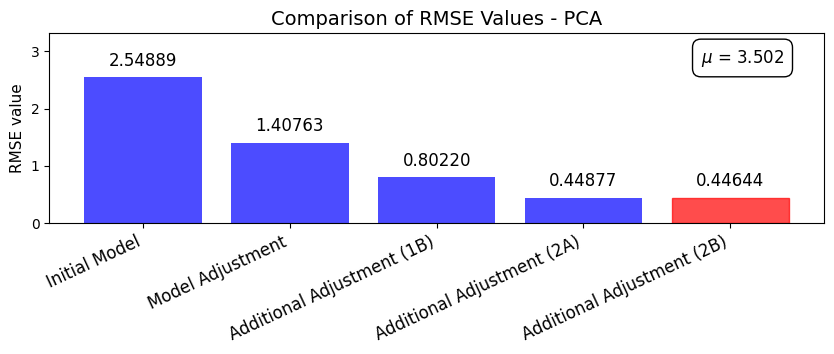

In [67]:
import matplotlib.pyplot as plt

rmse_values = [rmse1, rmse2, rmse4, rmse5, rmse6]

labels = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]

# minimum RMSE
min_rmse_index = rmse_values.index(min(rmse_values))

fig, ax = plt.subplots(figsize=(10, 5))

# Graphique RMSE
bars = ax.bar(labels, rmse_values, color="blue", alpha=0.7)

# Changer la couleur de la barre avec la valeur minimale
bars[min_rmse_index].set_color("red")  # Changer la couleur de la barre avec le RMSE minimum

ax.set_xticks(range(len(labels)))  
ax.set_xticklabels(labels, rotation=25, ha="right", fontsize=12)

for i, z in enumerate(rmse_values):
    ax.text(i, z + 0.2, f"{z:.5f}", ha='center', fontsize=12)

ax.set_ylim(0, max(rmse_values) * 1.3)  # Agrandir l'axe Y de 20 % par rapport à la valeur maximale
# legend
ax.text(3.8, max(rmse_values) * 1.1, f"$\\mu$ = {mu:.3f}", ha='left', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))


# Titre et labels
ax.set_title("Comparison of RMSE Values - PCA",fontsize= 14)
ax.set_ylabel("RMSE value",fontsize= 11)

# Ajuster la mise en page
plt.subplots_adjust(bottom=0.5)
plt.savefig("../Image/RMSE_barplot_pca.png", dpi=300, bbox_inches='tight')
plt.show()

#### MAE

In [68]:
mae1 = np.sum(np.abs((predict1 - Y) * R)) / nb_evaluation
mae2 = np.sum(np.abs((predict2 - Y) * R)) / nb_evaluation
mae4 = np.sum(np.abs((predict4 - Y) * R)) / nb_evaluation
mae5 = np.sum(np.abs((predict5 - Y) * R)) / nb_evaluation
mae6 = np.sum(np.abs((predict6 - Y) * R)) / nb_evaluation
print(f"La moyenne de toutes les notes attribuées (globale) : {mu}\n")
print("1.MAE du modèle initial:", mae1)
print("2.MAE de l'ajustement du modèle:", mae2)
print("4.MAE de l'ajustement supplémentaire du modèle (1B):", mae4)
print("5.MAE de l'ajustement supplémentaire du modèle (2A):", mae5)
print("6.MAE de l'ajustement supplémentaire du modèle (2B):", mae6,"\n")
print(f"La proportion de MAE 1 par rapport à la note moyenne globale.: {(mae1/mu)*100:0.3f} %" )
print(f"La proportion de MAE 2 par rapport à la note moyenne globale.: {(mae2/mu)*100:0.3f} %" )
print(f"La proportion de MAE 4 par rapport à la note moyenne globale.: {(mae4/mu)*100:0.3f} %" )
print(f"La proportion de MAE 4 par rapport à la note moyenne globale.: {(mae5/mu)*100:0.3f} %" )
print(f"La proportion de MAE 6 par rapport à la note moyenne globale.: {(mae6/mu)*100:0.3f} %" )
#dans le but de compararer avec les modeles utilisant PCA
cv_mae5 = (mae5/mu)*100
cv_mae6 = (mae6/mu)*100 

La moyenne de toutes les notes attribuées (globale) : 3.501527080895623

1.MAE du modèle initial: 2.2380225804935168
2.MAE de l'ajustement du modèle: 1.2365252358311611
4.MAE de l'ajustement supplémentaire du modèle (1B): 0.6050974251217391
5.MAE de l'ajustement supplémentaire du modèle (2A): 0.3371927583650479
6.MAE de l'ajustement supplémentaire du modèle (2B): 0.3350284331197945 

La proportion de MAE 1 par rapport à la note moyenne globale.: 63.916 %
La proportion de MAE 2 par rapport à la note moyenne globale.: 35.314 %
La proportion de MAE 4 par rapport à la note moyenne globale.: 17.281 %
La proportion de MAE 4 par rapport à la note moyenne globale.: 9.630 %
La proportion de MAE 6 par rapport à la note moyenne globale.: 9.568 %


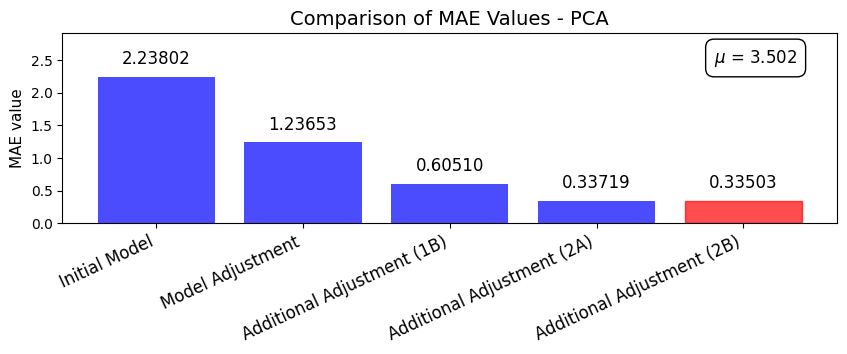

In [69]:
mae_values = [mae1, mae2, mae4, mae5, mae6]

labels = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]

#  minimum MAE
min_mae_index = mae_values.index(min(mae_values))

# la figure et des axes
fig, ax = plt.subplots(figsize=(10, 5))

# Graphique MAE
bars = ax.bar(labels, mae_values, color="blue", alpha=0.7)

# Changer la couleur de la barre avec la valeur minimale
bars[min_mae_index].set_color("red")  # Changer la couleur de la barre avec le MAE minimum

ax.set_xticks(range(len(labels)))  
ax.set_xticklabels(labels, rotation=25, ha="right", fontsize=12)

for i, z in enumerate(mae_values):
    ax.text(i, z + 0.2, f"{z:.5f}", ha='center', fontsize=12)

ax.set_ylim(0, max(mae_values) * 1.3) # Agrandir l'axe Y de 20 % par rapport à la valeur maximale

# legend
ax.text(3.8, max(mae_values) * 1.1, f"$\\mu$ = {mu:.3f}", ha='left', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

ax.set_title("Comparison of MAE Values - PCA",fontsize= 14)
ax.set_ylabel("MAE value",fontsize= 11)

plt.subplots_adjust(bottom=0.5)
plt.savefig("../Image/MAE_barplot_pca.png", dpi=300, bbox_inches='tight')
plt.show()

#### Pearson product-moment Correlation Coefficient (PCC)

In [70]:
mask = Y != 0
mu_hat1 = np.mean(predict1[mask])
mu_hat2 = np.mean(predict2[mask])
mu_hat4 = np.mean(predict4[mask])
mu_hat5 = np.mean(predict5[mask])
mu_hat6 = np.mean(predict6[mask])
print(f"La moyenne de Ymean : {np.mean(Ymean)}\n")
print(f"La moyenne de toutes les notes prédites (du modèle initial) : {mu_hat1}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement du modèle) : {mu_hat2}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (1B)) : {mu_hat4}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2A)) : {mu_hat5}")
print(f"La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2B)) : {mu_hat6}\n")
print(f"La moyenne de toutes les notes (globale) : {mu}")

La moyenne de Ymean : 3.2624895815718498

La moyenne de toutes les notes prédites (du modèle initial) : 1.3416147658624658
La moyenne de toutes les notes prédites (de l'ajustement du modèle) : 2.303959173313032
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (1B)) : 3.495087268418117
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2A)) : 3.508396071119693
La moyenne de toutes les notes prédites (de l'ajustement supplémentaire du modèle (2B)) : 3.5079245103391505

La moyenne de toutes les notes (globale) : 3.501527080895623


In [71]:
numerateur1 = ((predict1 - mu_hat1) * (Y - mu) * R).sum()
denominateur1 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict1 - mu_hat1)*R)**2).sum() )
pcc1 = numerateur1/denominateur1
print("PCC du modèle initial: ",pcc1)

numerateur2 = ((predict2 - mu_hat2) * (Y - mu) * R).sum()
denominateur2 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict2 - mu_hat2)*R)**2).sum() )
pcc2 = numerateur2/denominateur2
print("PCC de l'ajustement du modèle: ",pcc2)

numerateur4 = ((predict4 - mu_hat4) * (Y - mu) * R).sum()
denominateur4 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict4 - mu_hat4)*R)**2).sum() )
pcc4 = numerateur4/denominateur4
print("PCC de l'ajustement supplémentaire du modèle (1B): ",pcc4)

numerateur5 = ((predict5 - mu_hat5) * (Y - mu) * R).sum()
denominateur5 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict5 - mu_hat5)*R)**2).sum() )
pcc5 = numerateur5/denominateur5
print("PCC de l'ajustement supplémentaire du modèle (2A): ", pcc5)

numerateur6 = ((predict6 - mu_hat6) * (Y - mu) * R).sum()
denominateur6 = np.sqrt( (((Y - mu)*R)**2).sum() * (((predict6 - mu_hat6)*R)**2).sum() )
pcc6 = numerateur6/denominateur6
print("PCC de l'ajustement supplémentaire du modèle (2B): ", pcc6)

PCC du modèle initial:  0.2483388083134811
PCC de l'ajustement du modèle:  0.7159611875526876
PCC de l'ajustement supplémentaire du modèle (1B):  0.6412143337697397
PCC de l'ajustement supplémentaire du modèle (2A):  0.9356392508085715
PCC de l'ajustement supplémentaire du modèle (2B):  0.9360134739985783


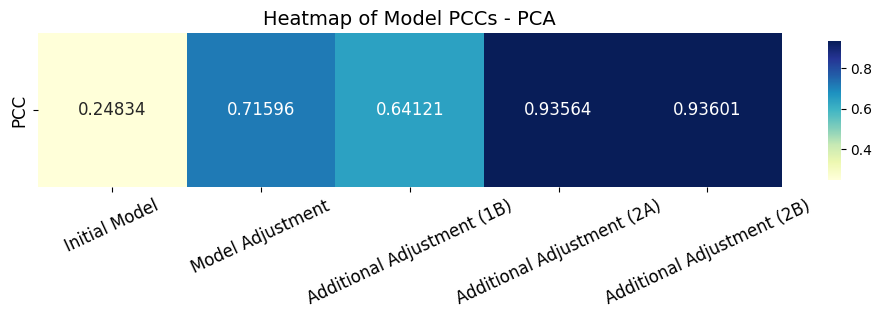

In [72]:
import seaborn as sns

pcc_values = [pcc1, pcc2, pcc4, pcc5, pcc6]
matrice_pcc = np.array(pcc_values).reshape(1, -1)

etiquettes = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]

# heatmap
plt.figure(figsize=(12, 2))
sns.heatmap(matrice_pcc, annot=True, fmt=".5f", xticklabels=etiquettes, yticklabels=["PCC"], cmap="YlGnBu",annot_kws={"size": 12},cbar_kws={"shrink": 0.9, "aspect": 11})
plt.xticks(rotation=25,fontsize=12)
plt.yticks(fontsize=12)
plt.title("Heatmap of Model PCCs - PCA",fontsize = 14)
plt.savefig("../Image/heatmap_pcc_pca.png", dpi=300, bbox_inches='tight')
plt.show()

In [73]:
import pickle

eva_model_pca = [rmse5, rmse6, mae5, mae6, cv_rmse5,cv_rmse6,cv_mae5,cv_mae6]

with open('var2.pkl', 'wb') as f:
    pickle.dump(eva_model_pca, f)

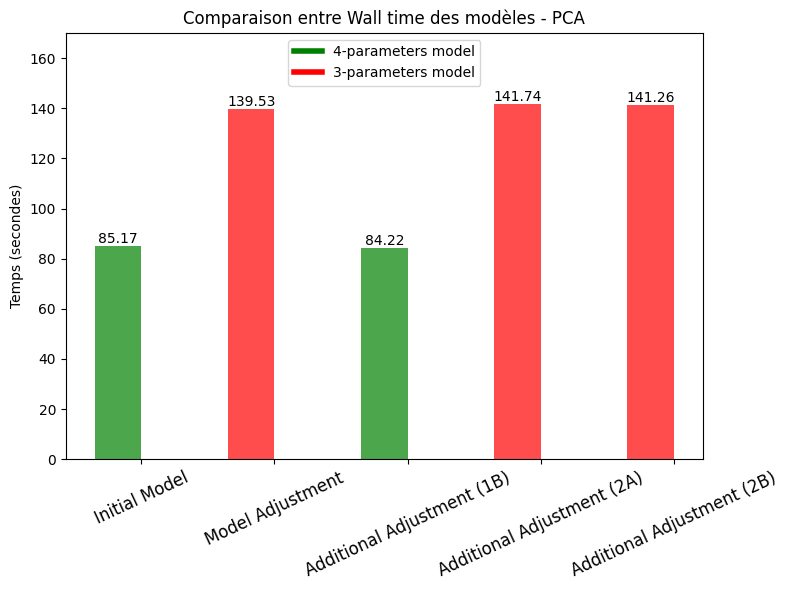

In [76]:
labels = [
    "Initial Model",
    "Model Adjustment",
    "Additional Adjustment (1B)",
    "Additional Adjustment (2A)",
    "Additional Adjustment (2B)"
]  

# Vérifier que les listes ont la même longueur
assert len(wall_times) == len(labels), "Les listes doivent avoir la même taille!"

# Positions sur l'axe des x
x = np.arange(len(labels))  
width = 0.35  # Largeur des barres

# Créer la figure et les axes
fig, ax = plt.subplots(figsize=(8, 6))

# Définir les couleurs pour chaque groupe
colors = ['g', 'r', 'g', 'r', 'r'] 
group_labels = ['4-parameters model', '3-parameters model', '4-parameters model', '3-parameters model', '3-parameters model']  

# Ajouter les barres pour Wall time avec couleurs spécifiées
bars1 = ax.bar(x - width/2, wall_times, width, color=colors, alpha=0.7)

# Ajouter les labels sur chaque barre
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Définir les limites de l'axe y
ax.set_ylim(0, max(wall_times) * 1.2)

# Ajouter des labels et un titre
ax.set_ylabel('Temps (secondes)')  # Étiquette de l'axe Y
ax.set_title('Comparaison entre Wall time des modèles - PCA', fontsize=12)  # Titre du graphique

# Ajouter les noms des tests sous les barres
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=25, fontsize=12)

# Ajouter une légende
from matplotlib.lines import Line2D

# Créer une légende personnalisée
legend_elements = [
    Line2D([0], [0], color='g', lw=4, label='4-parameters model'),
    Line2D([0], [0], color='r', lw=4, label='3-parameters model'),
]

ax.legend(handles=legend_elements, loc='upper center')

# Afficher le graphique
plt.tight_layout()
plt.savefig("../Image/walltime_pca.png", dpi=300, bbox_inches='tight')
plt.show()

**-----C'est fini-----**

[FAIRE DÉFILER VERS LE HAUT](#0)